# Watershed water budget mash-up

[Emilio Mayorga](https://github.com/emiliom), University of Washington &mdash; [WaterHackWeek 2020](https://waterhackweek.github.io/) &mdash; 2020-9-1

## Objective (aka Storyline)

**Construct a monthly (sub)watershed-scale water budget for the Upper Yakima watershed using geospatial watershed layers and a wide variety of water data, including remote sensing products, multi-source climate products, river discharge at a gage near the watershed outlet.**

## Goals

At the end of this tutorial, you will be able to do these tasks starting from remote data queries and access:

* Use `hydrodata` packages to access US hydrography geospatial datasets, specially watersheds (WBD/HUCs), based on specific criteria
* Transform geospatial vector data using `GeoPandas` and explore the data via interactive maps
* Use `xarray` to access a variety of spatial-temporal gridded data from different `OPeNDAP` sources and source types, specifying spatial and temporal subsets
* Use `rioxarray` to reproject spatial-temporal gridded data in NetCDF datasets that follow the `CF` convention
* Use `regionamsk` to define and apply regions and masks for performing spatial aggregations on diverse multi-dimensional gridded data, reducing these complex data to simple, watershed-wide time series
* Take your analysis from `xarray` DataArrays to `Pandas` DataFrames
* Mix data types with abandon, from multi-dimensional gridded data to geospatial vector layers to point time series

## Caveat

**There is a lot here!** Don't worry if you can't follow everything, or even most of it. Use this notebook as a resource to go back to. Pick whatever technique you're interested in.

## Import most of the required packages

In [1]:
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import contextily as cx
import folium

import numpy as np
import pandas as pd
import geopandas as gpd
from pyproj import CRS
import xarray as xr
import rioxarray
import regionmask as rm

----------------
## Read BigThompson (HUC8 code `10190006`) HUC8-level subwatersheds

We'll use the shorthand **"uy"** to refer to the Upper Yakima watershed.

**In the US,** consistent national watershed and hydrographic analysis is best carried out using the [National Hydrography Products](https://www.usgs.gov/core-science-systems/ngp/national-hydrography/access-national-hydrography-products) maintained by USGS. These products include the National Hydrography Dataset (NHD) and the [Watershed Boundary Dataset (WBD)](https://www.usgs.gov/core-science-systems/ngp/national-hydrography/watershed-boundary-dataset): "The hydrologic units (HU) in the WBD form a standardized system for organizing, collecting, managing, and reporting hydrologic information for the nation. The HU in the WBD are arranged in a nested, hierarchical system with each HU in the system identified using a unique code. Hydrologic unit codes (HUC) are developed using a progressive two-digit system where each successively smaller areal unit is identified by adding two digits to the identifying code the smaller unit is nested within. WBD contains eight levels of progressive hydrologic units identified by unique 2- to 16-digit codes."


**For global applications** (except very high latitudes), take a look at the [HydroBASINS](https://hydrosheds.org/pages/hydrobasins) dataset, based on [HydroSHEDS](https://hydrosheds.org/). HydroBASINS uses a different hierarchical watershed coding scheme (the "Pfastetter" system). For an example that uses a HydroBASINS dataset (and for `GeoPandas` tutorials), see the [GeoHackWeek Vector tutorial](https://geohackweek.github.io/vector/), specifically the [Advanced GeoPandas notebook](https://nbviewer.jupyter.org/github/geohackweek/tutorial_contents/blob/master/vector/notebooks/geopandas_advanced.ipynb).

![WBD Hydrologic Units](https://prd-wret.s3.us-west-2.amazonaws.com/assets/palladium/production/s3fs-public/styles/atom_page_medium/public/thumbnails/image/WBD_Base_HUStructure_small.png)

In [2]:
# These libraries are used only in this section
from shapely.geometry import box
import pynhd as nhd
import pygeoogc as geoogc
import pygeoutils as geoutils
import hydrodata as hd

The [PyNHD](https://github.com/cheginit/pynhd) package provides convenient access via remote queries to US watershed and hydrographic (river network, etc) spatial layers. This is much more convenient than finding and downloading large geospatial files, decompressing, then reading only the features (say, watersheds) we are interested in. `PyNHD` is part of the [hydrodata](https://hydrodata.readthedocs.io/) suite of packages developed by [Taher Chegini](https://github.com/cheginit), which also includes `PyGeoOGC` and `PyGeoUtils`, also used here. `hydrodata` packages were first released recently and are under active development; changes are expected.

The `PyNHD` `WaterData` class provides access to USGS hydrographic geospatial layers from the [USGS Water Data Labs](https://labs.waterdata.usgs.gov), "an experimental site that exposes tools and technologies in development by the USGS Water Data for the Nation software team". *(Note that these geospatial layers may change in the future, but most likely for the better. They may also be moved to a more permanent, operational service.)*

Here we're looking for HUC10-level sub-watersheds of the HUC8 Upper Yakima watershed (HUC8 code `17030001`). `WaterData` provides access to HUC8 and HUC12 layers, but unfortunately *not* HUC10 (because HUC10's are not available in the Water Data Labs web services; go figure). What we'll do below is to request the finer-scale HUC12 subwatersheds corresponding to HUC8 `17030001`, taking advantage of the hierarchical nature of HUC codes where the codes of finer-resolution (smaller) watersheds are built appending digits to the coarser-resolution watershed codes and the length of a HUC code is equal to its level: a HUC8 code has 8 digits, HUC12 has 12 digits, and so on. 

In [3]:
uy_huc08code = '10190006'

### Create HUC10 subwatersheds by first reading HUC12 subwatersheds

Request all HUC12 watersheds whose HUC12 code includes the Upper Yakima HUC8 code. This is done using an attribute-based filter in the web service request, using the [CQL spatial query language](https://docs.geoserver.org/latest/en/user/tutorials/cql/cql_tutorial.html), which has similarities with database querying in SQL.

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Note:</b> If we were interested in one or more specific HUC8 or HUC12 watersheds based on their exact codes, we could use <em>WaterData</em> functionality directly and conveniently, like this:
</div>

```python
uy_wdhuc08 = nhd.WaterData('huc08', crs='epsg:900913')
uy_huc08_gdf = uy_wdhuc08.byid('huc8', featureids=uy_huc08code)
```

In [4]:
def wfs_getfeatures_cqlfilter(wd, cql_filter=None):
    """
    Use hydrodata packages to issue and process a OpenGeospatial Consortium (OGC) Web Feature Service (WFS) 
    request for WBD watersheds, with an optional filter to obtain only the watersheds we want.
    Returns a nice and clean GeoPandas GeoDataframe in "lat-lon" projection (epsg:4326)
    """
    payload = {
        "service": "wfs",
        "request": "GetFeature",
        "version": wd.version,
        "outputFormat": wd.outformat,
        "typeName": wd.layer,
    }
    if type(cql_filter) is str:
        payload["cql_filter"] = cql_filter

    r = geoogc.RetrySession().get(wd.url, payload)
    
    return geoutils.json2geodf(r.json(), "epsg:4326", crs="epsg:4326")

In [5]:
uy_wdhuc12 = nhd.WaterData('huc12', crs='epsg:900913')

In [6]:
print(uy_wdhuc12.get_validnames())

['huc12', 'tohuc', 'areaacres', 'areasqkm', 'name', 'hutype', 'humod', 'states', 'noncontrib', 'bbox']


In [16]:
# HUC filter (cql_filter) will be the string "huc12 LIKE '17030001%'"
uy_huc12_gdf = wfs_getfeatures_cqlfilter(
    uy_wdhuc12, 
    cql_filter=f"huc12 LIKE '{uy_huc08code}%'"
)

uy_huc12_gdf.head(7)

,geometry,huc12,tohuc,areaacres,areasqkm,name,hutype,humod,states,noncontrib,bbox
0,"MULTIPOLYGON (((-105.49120 40.36910, -105.4866...",101900060206,101900060207,9989.451440,40.425876,Fish Creek,S,NM,CO,0,"[-105.545, 40.2885, -105.4684, 40.3704]"
1,"MULTIPOLYGON (((-105.18720 40.28520, -105.1856...",101900060502,101900060503,12078.875741,48.881476,Ish Reservoir-Little Thompson River,S,"RS,TF",CO,0,"[-105.2154, 40.2343, -105.0709, 40.3063]"
2,"MULTIPOLYGON (((-105.05710 40.34530, -105.0487...",101900060503,101900060504,22865.312055,92.532635,Handy Reservoir-Little Thompson River,S,"RS,TF",CO,0,"[-105.135, 40.2345, -104.9827, 40.3503]"
3,"MULTIPOLYGON (((-104.98610 40.33490, -104.9785...",101900060504,101900060606,19554.088786,79.132590,Outlet Little Thompson River,S,NM,CO,0,"[-105.0135, 40.2693, -104.8543, 40.3436]"
4,"MULTIPOLYGON (((-105.31120 40.50440, -105.3088...",101900060601,101900060603,12109.152777,49.004003,Cedar Creek,S,NM,CO,0,"[-105.3726, 40.4159, -105.2514, 40.5044]"
5,"MULTIPOLYGON (((-105.07800 40.39150, -105.0758...",101900060604,101900060605,17103.773355,69.216515,Mariano Reservoir-Big Thompson River,S,NM,CO,0,"[-105.1933, 40.3133, -105.0735, 40.4394]"
6,"MULTIPOLYGON (((-105.33250 40.41610, -105.3286...",101900060602,UNKNOWN,23941.660032,96.888461,Dry Creek,S,NM,CO,0,"[-105.3526, 40.3077, -105.1479, 40.4161]"


Create `huc10` column from `huc12` codes. Ideally we'd like to have the huc10 name (but it's not available) and other huc attributes.

In [8]:
uy_huc12_gdf['huc10'] = uy_huc12_gdf.huc12.str[:-2]
cols = ['huc10', 'areasqkm', 'geometry']
uy_huc10_gdf = uy_huc12_gdf[cols].dissolve(by='huc10', aggfunc='sum', as_index=False)

len(uy_huc10_gdf)

6

In [9]:
uy_huc10_gdf.head(2)

,huc10,geometry,areasqkm
0,1019000601,"POLYGON ((-105.41470 40.49760, -105.41520 40.4...",220.738570
1,1019000602,"POLYGON ((-105.47190 40.35630, -105.47250 40.3...",494.144254


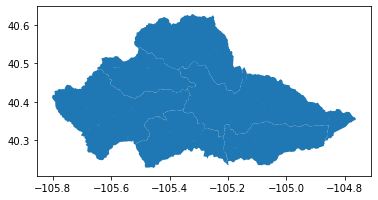

In [10]:
uy_huc10_gdf.plot();

We'll use the `total_bounds` GeoDataFrame function to extract the outer bounding box coordinates, then create a simple GeoSeries out of that rectangle for reuse later on.

In [11]:
uy_huc10_gdf.total_bounds

array([-105.8033,   40.2271, -104.7605,   40.629 ])

In [17]:
uy_bbox = gpd.GeoSeries(box(*uy_huc10_gdf.total_bounds), crs=uy_huc10_gdf.crs)

Set `xarray` spatial (lat & lon) "slices" here, for reuse below when doing lat-lon region clipping (via the `.sel` method) of `xarray` datasets.

In [18]:
uy_lon_slice = slice(uy_bbox.bounds.minx[0], uy_bbox.bounds.maxx[0])
uy_lat_slice = slice(uy_bbox.bounds.miny[0], uy_bbox.bounds.maxy[0])

Let's plot nicer maps, to get a better geographical context.

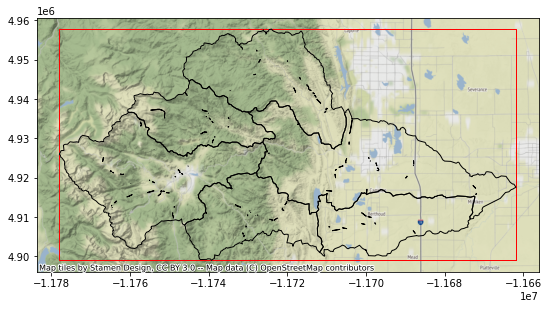

In [19]:
# Project the geopandas datasets to 3857 (web mercator, "Google Maps") 
# so the basemap is not warped and interpolated and will render more quickly
ax = uy_bbox.to_crs(epsg=3857).plot(edgecolor="red", facecolor='none', figsize=(9, 9))
uy_huc10_gdf.to_crs(epsg=3857).plot(ax=ax, edgecolor='black', facecolor='none')
cx.add_basemap(ax)

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Note:</b> Many of the WBD watershed polygons have tiny "holes" in them! They could be messiness and oversights in the source dataset, but they may also be "sliver polygons" resulting frrom the `dissolve` operation. They won't impact our analysis.
</div>

But using an interactive [**Folium**](https://python-visualization.github.io/folium/) map may be faster and more convenient. Plus we can make the watershed polygons clickable, with a popup that provides helpful information!

In [20]:
# Note: There are other basemap tiles besides StamenTerrain
m = folium.Map(tiles='StamenTerrain', attr='ESRI')

In [21]:
# Bounding box
folium.GeoJson(
    uy_bbox.geometry,
    style_function=lambda feature: {'color': 'red', 'fillOpacity': 0.0}
).add_to(m)

# Set the map extent (bounds) to the extent of the bounding box
m.fit_bounds(m.get_bounds())

# HUC10 sub-watershed polygons
for i, i_gdf in uy_huc10_gdf.iterrows():
    folium.GeoJson(
        i_gdf.geometry,
        style_function=lambda feature: {'color': 'black', 'fillOpacity': 0.0},
        tooltip=i_gdf['huc10']
    ).add_child(
        folium.Popup(f"<b>HUC10:</b><br> {i_gdf['huc10']}<br><b>watershed area:</b><br> {i_gdf['areasqkm']:.0f} km^2")
    ).add_to(m)

In [22]:
m

## Set the time period for analysis: 2010-2019

To be reused with every dataset.

In [25]:
date_start = '2010-1-1'
date_end = '2020-1-1'

----------------

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Read spatial-temporal gridded data from remote sources</b></br>

We will now read spatial-temporal (multi-dimensional) gridded data that cover our study watershed (**Upper Yakima**) and the target time period (**one year, 2016**). These data will be accessed dynamically from remote data services and processed to a common spatial and temporal domains.

</div>

## READ WATER DATA: Precipitation from DayMet
<div class="alert alert-info" style="font-size:100%">

Access DayMet daily precipitation data from the same remote source (THREDDS catalog and OPeNDAP access protocol) used in the Gridded Data tutorial. It's a very large dataset (dimensions: time: 14600, x: 7814, y: 8075), so <b>be careful how much data you request!</b> Also, as we'll see it's in a <a href="https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection">Lambert Conformal Conic (equal area) projection</a>, not lat-lon. We'll need to <b>reproject it to epsg:4326</b> to mash it up with other data.

</div>

### Read the remote dataset (metadata only, initially -- "lazy loading")

In [26]:
daymet_opendap_url = "https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml"
    
daymet_ds = xr.open_dataset(daymet_opendap_url)

In [27]:
daymet_ds

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14600, x: 7814, y: 8075)
Coordinates:
  * x                        (x) float32 -4560250.0 -4559250.0 ... 3252750.0
  * y                        (y) float32 4984000.0 4983000.0 ... -3090000.0
  * time                     (time) datetime64[ns] 1980-01-01 ... 2019-12-31
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 ...
    yearday                  (time) int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    dayl                     (time, y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    title:             Daymet: Daily Surface Weather Data on a 1-km Grid for ...
    institution:       Oak Ridge National Laboratory Distributed Active Archi...
    end_year:          2019

Examine the Coordinate Reference System (`grid_mapping`) variable `daymet_ds.lambert_conformal_conic` in the dataset browser, above. Like many NetCDF datasets, it follows (more or less ...) the [CF (Climate and Forecast) Convention](http://cfconventions.org), including the CF convention for representing the geospatial projection.

### Get the BigThompson bounding box in the DayMet projection coordinates

In [28]:
daymet_ds_grid_mapping_name = 'lambert_conformal_conic'

In [29]:
# DayMet crs information is in: ds.lambert_conformal_conic ('lcc')
lcc_crs = CRS.from_cf(daymet_ds[daymet_ds_grid_mapping_name].attrs)

In [30]:
lcc_crs

<Projected CRS: {"$schema": "https://proj.org/schemas/v0.2/projjso ...>
Name: undefined
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Lambert Conic Conformal (2SP)
Datum: undefined
- Ellipsoid: undefined
- Prime Meridian: undefined

In [31]:
# Reproject our bounding box polygon into this new coordinate system, to use in our request
uy_bbox_lcc = uy_bbox.to_crs(lcc_crs)

In [32]:
uy_lcc_bnd = uy_bbox_lcc.bounds

### Get the DayMet precipitation data for the selected XYT "cube"

After examining the metadata, we can see that y-axis coordinate values in `daymet_ds` **decrease**! The expectation in many of the tools we'll use is that they increase. This is unexpected, but most data invariably have some messiness.

This statement is fast because it doesn't yet read the data from the remote THREDDS server. It uses "lazy loading" -- the data are requested only when actually needed for a calculation or plot. **We specifically structure the data request and sequence of steps to minimize the amount of data we're asking from the server once we need it.**

In [33]:
uy_daymet_prcp_da = daymet_ds.prcp.sel(
    time=slice(date_start, date_end),
    x=slice(uy_lcc_bnd.minx[0], uy_lcc_bnd.maxx[0]),
    y=slice(uy_lcc_bnd.maxy[0], uy_lcc_bnd.miny[0]) # note the reversed y values!
)

In [34]:
uy_daymet_prcp_da

<xarray.DataArray 'prcp' (time: 3650, y: 48, x: 87)>
[15242400 values with dtype=float32]
Coordinates:
  * x        (x) float32 -470250.0 -469250.0 -468250.0 ... -385250.0 -384250.0
  * y        (y) float32 -182000.0 -183000.0 -184000.0 ... -228000.0 -229000.0
  * time     (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2019-12-31
    lat      (y, x) float32 ...
    lon      (y, x) float32 ...
Attributes:
    long_name:     daily total precipitation
    units:         mm/day
    grid_mapping:  lambert_conformal_conic
    cell_methods:  area: mean time: sum

## Reproject to lat-lon in order to use it together with all other datasets

But will need to pre-process it so `rioxarray` can reproject the xarray dataset

In [49]:
def reproject_da_as_ds(da, from_grid_mapping_name, from_crs, to_crs):
    """
    Reproject an xarray DataArray using rioxarray and the expectation of CF convention 
    for projection information.
    This function is fairly generic and can be reused with other datasets with only small changes.
    Returns an xarray DataSet with the expected, CF-convention projection information.
    """
    ds = da.to_dataset()
    # Use rioxarray to improve (clean up) the CRS metadata, 
    # so it can be used in the reprojection step
    ds.rio.write_crs(from_crs.to_string(), inplace=True)
    
    # Reproject the xarray dataset
    # Note: the drop_vars step could be done outside this function, since it's source-data cleanup
    reproj_ds = (
        ds
        .drop_vars(['lon', 'lat'])
        .rio.reproject(to_crs)
    )
    
    # Clean up the projection information and coordinates of the reprojected dataset
    to_grid_mapping_name = reproj_ds[from_grid_mapping_name].attrs['grid_mapping_name']
    reproj_ds = (
        reproj_ds
        .rio.set_spatial_dims('x', 'y')
        .rio.write_crs(to_crs)
        .rename({"x": "lon", "y": "lat", from_grid_mapping_name: to_grid_mapping_name}) 
        # this last step applies only when reprojecting to lat-lon
    )
    reproj_ds.attrs['grid_mapping'] = to_grid_mapping_name
    reproj_ds[da.name].attrs['grid_mapping'] = to_grid_mapping_name
    
    return reproj_ds

In [48]:
uy_daymet_prcp_ds = reproject_da_as_ds(uy_daymet_prcp_da, daymet_ds_grid_mapping_name, lcc_crs, "epsg:4326")

In [50]:
uy_daymet_prcp_ds

<xarray.Dataset>
Dimensions:             (lat: 42, lon: 93, time: 3650)
Coordinates:
  * lon                 (lon) float64 -105.8 -105.8 -105.8 ... -104.7 -104.7
  * lat                 (lat) float64 40.68 40.67 40.65 ... 40.21 40.2 40.19
  * time                (time) datetime64[ns] 2010-01-01 ... 2019-12-31
    latitude_longitude  int64 0
Data variables:
    prcp                (time, lat, lon) float32 nan nan nan nan ... nan nan nan
Attributes:
    grid_mapping:  latitude_longitude

Quick check on the resulting cell sizes, in degrees

In [43]:
def print_cellsizes(dimcoord):
    print(dimcoord.values[1] - dimcoord.values[0], dimcoord.values[-1] - dimcoord.values[-2])

In [44]:
print_cellsizes(uy_daymet_prcp_ds.lon)

0.01186755071681489 0.01186755071681489


In [41]:
print_cellsizes(uy_daymet_prcp_ds.lat)

-0.011867550716821995 -0.011867550716821995


Let's see it! Here we use `.isel` to pick the "5th time step from the end" (why not).

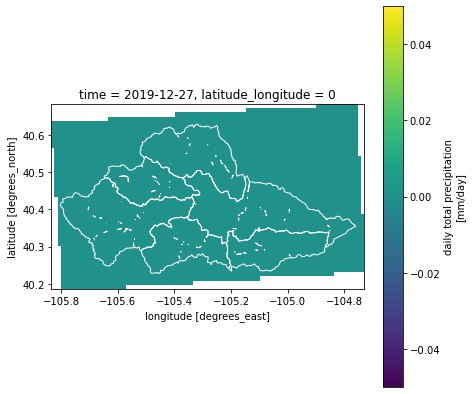

In [45]:
f, ax = plt.subplots(1, figsize=(7, 7))
uy_daymet_prcp_ds.prcp.isel(time=-5).plot(ax=ax)
uy_huc10_gdf.plot(ax=ax, edgecolor='white', facecolor='none');

Clip further, to `uy_bbox` bounding box (via `uy_lon_slice` and `uy_lat_slice`). This will make for a smaller dataset, therefore faster processing. We use the `rioxarray` `clip` function (`rio.clip`).

In [46]:
uy_daymet_prcp_ds = uy_daymet_prcp_ds.rio.clip(uy_huc10_gdf.geometry, all_touched=True)

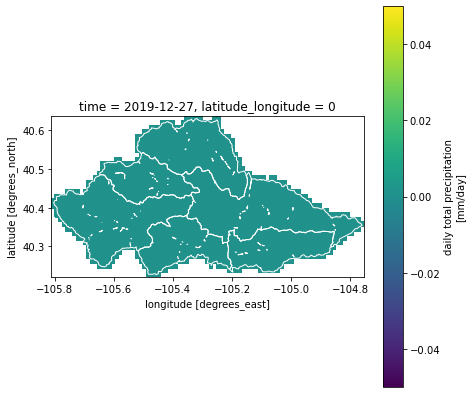

In [47]:
f, ax = plt.subplots(1, figsize=(7, 7))
uy_daymet_prcp_ds.prcp.isel(time=-5).plot(ax=ax)
uy_huc10_gdf.plot(ax=ax, edgecolor='white', facecolor='none');

----------------
## READ WATER DATA: Evapotranspiration from SSBo ETa

<div class="alert alert-info" style="font-size:100%">
Simplified Surface Energy Balance Actual Evapotranspiration (ETa) data for the Conterminous U.S., produced using the operational Simplified Surface Energy Balance (SSEBop) model based on MODIS remote sensing data.
</div>

- Monthly Conterminous U.S. actual evapotranspiration data. Time range available: 2000-01-01 - 2019-10-01
- Dataset description: See [here](https://cida.usgs.gov/gdp/client/#!catalog/gdp/dataset/54dd5d21e4b08de9379b38b6), [here](https://earlywarning.usgs.gov/ssebop/modis/daily), and [here](https://earlywarning.usgs.gov/docs/USA_DAILYSSEBopETa_Oct2019.pdf)
- Available from a THREDDS server: https://cida.usgs.gov/thredds/catalog.html?dataset=cida.usgs.gov/ssebopeta/monthly
- This is the "cleanest" of the 3 gridded datasets! It requires no additional cleaning.

In [51]:
ssebop_opendap_url = "https://cida.usgs.gov/thredds/dodsC/ssebopeta/monthly"

ssebop_ds = xr.open_dataset(ssebop_opendap_url)

In [52]:
ssebop_ds

<xarray.Dataset>
Dimensions:  (lat: 2834, lon: 6612, time: 238)
Coordinates:
  * time     (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2019-10-01
  * lon      (lon) float64 -126.0 -126.0 -126.0 -126.0 ... -66.51 -66.51 -66.5
  * lat      (lat) float64 24.0 24.01 24.02 24.03 ... 49.47 49.48 49.49 49.5
Data variables:
    crs      |S64 ...
    et       (time, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    title:                           Conterminous U.S. actual evapotranspirat...
    creator_name:                    Stefanie Kagone
    creator_email:                   skagone@contractor.usgs.gov
    summary:                         Actual ET (ETa) is produced using the op...
    cdm_data_type:                   Grid
    date_created:                    February, 2013
    date_modified:                   December, 2019
    creator_url:                     https://earlywarning.usgs.gov/ssebop/modis
    publisher_name:                  David Blodgett
    publisher_url:                   https://cida.usgs.gov/
    publisher_email:                 dblodgett@usgs.gov
    institution:                     U.S. Geological Survey
    date_issued:                     February, 2013
    project:                         WaterSMART National Water Census
    processing_level:                Refer to documentation.
    acknowledgement:                 Senay, G.B., M. Budde, J.P. Verdin, and ...
    contributors:                    Senay, G.B., S. Bohms, R. Singh, P.A. Go...
    geospatial_lat_min:              24
    geospatial_lat_max:              49.5
    geospatial_lon_min:              -126
    geospatial_lon_max:              -66.5
    time_coverage_resolution:        P1Y
    license:                         Freely available
    DODS.strlen:                     238
    DODS.dimName:                    time
    DODS_EXTRA.Unlimited_Dimension:  time

In [53]:
ssebop_ds.rio.write_crs(CRS.from_cf(ssebop_ds['crs'].attrs), inplace=True);

In [54]:
ssebop_ds.time.values[0:3]

array(['2000-01-01T00:00:00.000000000', '2000-02-01T00:00:00.000000000',
       '2000-03-01T00:00:00.000000000'], dtype='datetime64[ns]')

In [55]:
uy_ssebop_et_ds = ssebop_ds.sel(time=slice(date_start, date_end), lon=uy_lon_slice, lat=uy_lat_slice)

uy_ssebop_et_ds

<xarray.Dataset>
Dimensions:  (lat: 44, lon: 116, time: 118)
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-02-01 ... 2019-10-01
    crs      int64 0
  * lon      (lon) float64 -105.8 -105.8 -105.8 -105.8 ... -104.8 -104.8 -104.8
  * lat      (lat) float64 40.23 40.24 40.25 40.26 ... 40.59 40.6 40.61 40.62
Data variables:
    et       (time, lat, lon) float32 ...
Attributes:
    Conventions:                     CF-1.5
    _NCProperties:                   version=2,netcdf=4.6.3,hdf5=1.10.5
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    title:                           Conterminous U.S. actual evapotranspirat...
    creator_name:                    Stefanie Kagone
    creator_email:                   skagone@contractor.usgs.gov
    summary:                         Actual ET (ETa) is produced using the op...
    cdm_data_type:                   Grid
    date_created:                    February, 2013
    date_modified:                   December, 2019
    creator_url:                     https://earlywarning.usgs.gov/ssebop/modis
    publisher_name:                  David Blodgett
    publisher_url:                   https://cida.usgs.gov/
    publisher_email:                 dblodgett@usgs.gov
    institution:                     U.S. Geological Survey
    date_issued:                     February, 2013
    project:                         WaterSMART National Water Census
    processing_level:                Refer to documentation.
    acknowledgement:                 Senay, G.B., M. Budde, J.P. Verdin, and ...
    contributors:                    Senay, G.B., S. Bohms, R. Singh, P.A. Go...
    geospatial_lat_min:              24
    geospatial_lat_max:              49.5
    geospatial_lon_min:              -126
    geospatial_lon_max:              -66.5
    time_coverage_resolution:        P1Y
    license:                         Freely available
    DODS.strlen:                     238
    DODS.dimName:                    time
    DODS_EXTRA.Unlimited_Dimension:  time
    grid_mapping:                    crs

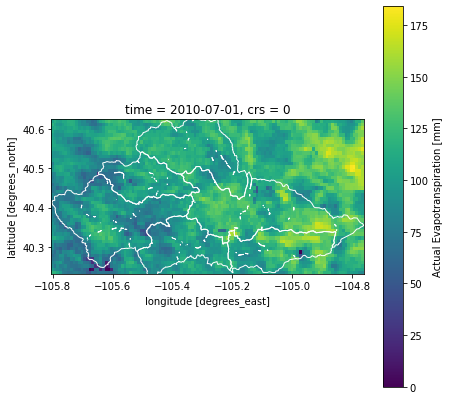

In [56]:
f, ax = plt.subplots(1, figsize=(7, 7))
uy_ssebop_et_ds.et.isel(time=6).plot(ax=ax)
uy_huc10_gdf.plot(ax=ax, edgecolor='white', facecolor='none');

----------------
## READ WATER DATA: Water storage (liquid and solid) from GRACE

<div class="alert alert-info" style="font-size:100%">

Ocean, Ice, and Hydrology Equivalent Water Height, derived from small changes in gravity over time. "JPL GRACE and GRACE-FO Mascon Ocean, Ice, and Hydrology Equivalent Water Height Coastal Resolution Improvement (CRI) Filtered Release 06 Version 02. This dataset contains gridded monthly global water storage/height anomalies relative to a time-mean, derived from GRACE and GRACE-FO and processed at JPL using the Mascon approach (Version2/RL06)." 
</div>

- "Liquid Water Equaivalent Thickness"
- Monthly dataset, with some gaps
- Very coarse, 0.5 degrees cells! Not much spatial differentiation within the Upper Yakima.
- From NASA JPL "PODAAC". Dataset description [here](https://podaac.jpl.nasa.gov/dataset/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06_V2), including links to the OPeNDAP data service "endpoint".

In [57]:
grace_opendap_url = "https://podaac-opendap.jpl.nasa.gov/opendap/allData/tellus/L3/mascon/RL06/JPL/v02/CRI/netcdf/GRCTellus.JPL.200204_202006.GLO.RL06M.MSCNv02CRI.nc"

grace_ds = xr.open_dataset(grace_opendap_url)

In [58]:
grace_ds

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 360, lon: 720, time: 186)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2020-06-16
Dimensions without coordinates: bounds
Data variables:
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
Attributes:
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform:                      GRACE and GRACE-FO
    institution:                   NASA/JPL
    creator_name:                  David Wiese
    creator_email:                 grace@podaac.jpl.nasa.gov
    creator_url:                   https://grace.jpl.nasa.gov
    creator_type:                  group
    creator_institution:           NASA/JPL
    publisher_name:                Physical Oceanography Distributed Active A...
    publisher_email:               podaac@jpl.nasa.gov
    publisher_url:                 https://podaac.jpl.nasa.gov
    publisher_type:                group
    publisher_institution:         NASA/JPL
    project:                       NASA Gravity Recovery and Climate Experime...
    program:                       NASA Earth Science System Pathfinder and N...
    id:                            10.5067/TEMSC-3JC62
    naming_authority:              org.doi.dx
    source:                        GRACE and GRACE-FO JPL RL06Mv2-CRI
    processing_level:              2 and 3
    acknowledgement:               GRACE is a joint mission of NASA (USA) and...
    license:                       https://science.nasa.gov/earth-science/ear...
    product_version:               v2.0
    time_epoch:                    2002-01-01T00:00:00Z
    time_coverage_start:           2002-04-16T00:00:00Z
    time_coverage_end:             2020-06-16T23:59:59Z
    geospatial_lat_min:            -89.75
    geospatial_lat_max:            89.75
    geospatial_lat_units:          degrees_north
    geospatial_lat_resolution:     0.5 degree grid; however the native resolu...
    geospatial_lon_min:            0.25
    geospatial_lon_max:            359.75
    geospatial_lon_units:          degrees_east
    geospatial_lon_resolution:     0.5 degree grid; however the native resolu...
    time_mean_removed:             2004.000 to 2009.999
    months_missing:                2002-06;2002-07;2003-06;2011-01;2011-06;20...
    postprocess_1:                  OCEAN_ATMOSPHERE_DEALIAS_MODEL (GAD), MON...
    postprocess_2:                 Water density used to convert to equivalen...
    postprocess_3:                 Coastline Resolution Improvement (CRI) fil...
    GIA_removed:                   ICE6G-D; Peltier, W. R., D. F. Argus, and ...
    geocenter_correction:          We use a version of TN-13 based on the JPL...
    C_20_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    d

In [59]:
grace_ds.lon.values.min(), grace_ds.lon.values.max()

(0.25, 359.75)

**NOTE:** `lon` values are 0 - 360 (starting from the anti-meridian, "-180") rather than -180 to 180 as the previous datasets! We'll need to add an offset in the lon slice specification, and will also need to restructure / shift the xarray dataset to make it work with the region mask and GeoDataFrame overlays. **Real data are messy!**

In [60]:
uy_grace_lwe_thickness_ds = grace_ds.sel(
    time=slice(date_start, date_end), 
    lon=slice(360 + uy_bbox.bounds.minx[0] - 0.5, 360 + uy_bbox.bounds.maxx[0] + 0.5), 
    lat=slice(uy_bbox.bounds.miny[0] - 0.5, uy_bbox.bounds.maxy[0] + 0.5), 
)

uy_grace_lwe_thickness_ds

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 3, lon: 4, time: 90)
Coordinates:
  * lon            (lon) float64 253.8 254.2 254.8 255.2
  * lat            (lat) float64 39.75 40.25 40.75
  * time           (time) datetime64[ns] 2010-01-16T12:00:00 ... 2019-12-16T1...
Dimensions without coordinates: bounds
Data variables:
    lat_bounds     (lat, bounds) float64 39.5 40.0 40.0 40.5 40.5 41.0
    lon_bounds     (lon, bounds) float64 253.5 254.0 254.0 ... 255.0 255.0 255.5
    time_bounds    (time, bounds) datetime64[ns] 2010-01-01 ... 2019-12-31T23...
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
Attributes:
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform:                      GRACE and GRACE-FO
    institution:                   NASA/JPL
    creator_name:                  David Wiese
    creator_email:                 grace@podaac.jpl.nasa.gov
    creator_url:                   https://grace.jpl.nasa.gov
    creator_type:                  group
    creator_institution:           NASA/JPL
    publisher_name:                Physical Oceanography Distributed Active A...
    publisher_email:               podaac@jpl.nasa.gov
    publisher_url:                 https://podaac.jpl.nasa.gov
    publisher_type:                group
    publisher_institution:         NASA/JPL
    project:                       NASA Gravity Recovery and Climate Experime...
    program:                       NASA Earth Science System Pathfinder and N...
    id:                            10.5067/TEMSC-3JC62
    naming_authority:              org.doi.dx
    source:                        GRACE and GRACE-FO JPL RL06Mv2-CRI
    processing_level:              2 and 3
    acknowledgement:               GRACE is a joint mission of NASA (USA) and...
    license:                       https://science.nasa.gov/earth-science/ear...
    product_version:               v2.0
    time_epoch:                    2002-01-01T00:00:00Z
    time_coverage_start:           2002-04-16T00:00:00Z
    time_coverage_end:             2020-06-16T23:59:59Z
    geospatial_lat_min:            -89.75
    geospatial_lat_max:            89.75
    geospatial_lat_units:          degrees_north
    geospatial_lat_resolution:     0.5 degree grid; however the native resolu...
    geospatial_lon_min:            0.25
    geospatial_lon_max:            359.75
    geospatial_lon_units:          degrees_east
    geospatial_lon_resolution:     0.5 degree grid; however the native resolu...
    time_mean_removed:             2004.000 to 2009.999
    months_missing:                2002-06;2002-07;2003-06;2011-01;2011-06;20...
    postprocess_1:                  OCEAN_ATMOSPHERE_DEALIAS_MODEL (GAD), MON...
    postprocess_2:                 Water density used to convert to equivalen...
    postprocess_3:                 Coastline Resolution Improvement (CRI) fil...
    GIA_removed:                   ICE6G-D; Peltier, W. R., D. F. Argus, and ...
    geocenter_correction:          We use a version of TN-13 based on the JPL...
    C_20_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. 

In [61]:
uy_grace_lwe_thickness_ds.coords['lon'] = (uy_grace_lwe_thickness_ds.coords['lon'] + 180) % 360 - 180
uy_grace_lwe_thickness_ds = uy_grace_lwe_thickness_ds.sortby(uy_grace_lwe_thickness_ds.lon)

In [62]:
uy_grace_lwe_thickness_ds

<xarray.Dataset>
Dimensions:        (bounds: 2, lat: 3, lon: 4, time: 90)
Coordinates:
  * lon            (lon) float64 -106.2 -105.8 -105.2 -104.8
  * lat            (lat) float64 39.75 40.25 40.75
  * time           (time) datetime64[ns] 2010-01-16T12:00:00 ... 2019-12-16T1...
Dimensions without coordinates: bounds
Data variables:
    lat_bounds     (lat, bounds) float64 39.5 40.0 40.0 40.5 40.5 41.0
    lon_bounds     (lon, bounds) float64 253.5 254.0 254.0 ... 255.0 255.0 255.5
    time_bounds    (time, bounds) datetime64[ns] 2010-01-01 ... 2019-12-31T23...
    lwe_thickness  (time, lat, lon) float64 3.491 3.491 3.491 ... 5.995 22.56
    uncertainty    (time, lat, lon) float64 2.351 2.351 2.351 ... 1.798 1.983
Attributes:
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06Mv2 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    keywords_vocabulary:           NASA Global Change Master Directory (GCMD)...
    platform:                      GRACE and GRACE-FO
    institution:                   NASA/JPL
    creator_name:                  David Wiese
    creator_email:                 grace@podaac.jpl.nasa.gov
    creator_url:                   https://grace.jpl.nasa.gov
    creator_type:                  group
    creator_institution:           NASA/JPL
    publisher_name:                Physical Oceanography Distributed Active A...
    publisher_email:               podaac@jpl.nasa.gov
    publisher_url:                 https://podaac.jpl.nasa.gov
    publisher_type:                group
    publisher_institution:         NASA/JPL
    project:                       NASA Gravity Recovery and Climate Experime...
    program:                       NASA Earth Science System Pathfinder and N...
    id:                            10.5067/TEMSC-3JC62
    naming_authority:              org.doi.dx
    source:                        GRACE and GRACE-FO JPL RL06Mv2-CRI
    processing_level:              2 and 3
    acknowledgement:               GRACE is a joint mission of NASA (USA) and...
    license:                       https://science.nasa.gov/earth-science/ear...
    product_version:               v2.0
    time_epoch:                    2002-01-01T00:00:00Z
    time_coverage_start:           2002-04-16T00:00:00Z
    time_coverage_end:             2020-06-16T23:59:59Z
    geospatial_lat_min:            -89.75
    geospatial_lat_max:            89.75
    geospatial_lat_units:          degrees_north
    geospatial_lat_resolution:     0.5 degree grid; however the native resolu...
    geospatial_lon_min:            0.25
    geospatial_lon_max:            359.75
    geospatial_lon_units:          degrees_east
    geospatial_lon_resolution:     0.5 degree grid; however the native resolu...
    time_mean_removed:             2004.000 to 2009.999
    months_missing:                2002-06;2002-07;2003-06;2011-01;2011-06;20...
    postprocess_1:                  OCEAN_ATMOSPHERE_DEALIAS_MODEL (GAD), MON...
    postprocess_2:                 Water density used to convert to equivalen...
    postprocess_3:                 Coastline Resolution Improvement (CRI) fil...
    GIA_removed:                   ICE6G-D; Peltier, W. R., D. F. Argus, and ...
    geocenter_correction:          We use a version of TN-13 based on the JPL...
    C_20_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese

Pretty low resolution ... But there is nothing like GRACE data for net water storage (mass) change.

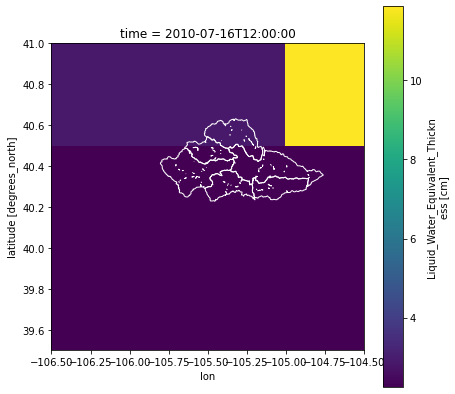

In [63]:
f, ax = plt.subplots(1, figsize=(7, 7))
uy_grace_lwe_thickness_ds.lwe_thickness.isel(time=6).plot(ax=ax)
uy_huc10_gdf.plot(ax=ax, edgecolor='white', facecolor='none');

----------------
## Generate HUC10-level watershed time series means using watershed regions and mask
Use regionmask to generate huc10 regions, mask, and time series averages

<div class="alert alert-info" style="font-size:100%">

We'll use <a href="https://regionmask.readthedocs.io">regionmask</a> to easily and cleanly generate "regions" from the HUC10 GeoDataFrame and a mask for these regions gridded to the grid of each input dataset.

<b>REGIONMASK LIMITATION:</b> <a href="https://github.com/mathause/regionmask/issues/151">regionmask is hard-wired to work only with data in lat-lon coordinates!</a>
</div>

### Create `regionmask` regions from a GeoDataFrame

In [64]:
uy_huc10_regions = rm.from_geopandas(
    uy_huc10_gdf, names="huc10", name="huc10"
)

uy_huc10_regions

<regionmask.Regions>
Name:     huc10

Regions:
 0  r0  1019000601
 1  r1  1019000602
 2  r2  1019000603
 3  r3  1019000604
 4  r4  1019000605
 5  r5  1019000606

[6 regions]

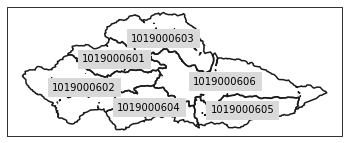

In [65]:
uy_huc10_regions.plot(label="name");

### HUC10 watershed time series means

In [66]:
def generate_huc10_ts(regions, ds, dsvarname, crsvar=None):
    """
    Use regionmask to create a gridded mask from the regions and the xarray dataset's
    grid resolution. Copy the variable attributes from the source DataSet to the 
    output DataArray.
    Returns a DataArray
    """
    mask3d = regions.mask_3D(ds, drop=False)

    # Latitude weighting for area-weighted averaging.
    # But it's probably unnecessary for this small geographical extent of the Upper Yakima
    weights = np.cos(np.deg2rad(ds.lat))
    regions_ts = ds[dsvarname].weighted(mask3d * weights).mean(dim=("lat", "lon"))
    # Assign dataarray name, and variable long name and units to region_ts, from ds[dsvarname]
    regions_ts.name = dsvarname
    regions_ts.attrs['long_name'] = ds[dsvarname].attrs['long_name']
    regions_ts.attrs['units'] = ds[dsvarname].attrs['units']
    
    # if present, drop crs variable b/c it's not needed anymore
    if crsvar in ds:
        regions_ts = regions_ts.drop_vars(crsvar)
    
    return regions_ts

#### Precipitation

In [67]:
daymet_prcp_regions_ts_daily = generate_huc10_ts(uy_huc10_regions, uy_daymet_prcp_ds, 'prcp', crsvar='latitude_longitude')

In [68]:
daymet_prcp_regions_ts_daily

<xarray.DataArray 'prcp' (time: 3650, region: 6)>
array([[0.38674183, 1.96487348, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 1.77399262, 0.        , 0.        , 0.        ,
        0.        ],
       [0.31535858, 1.1081468 , 0.        , 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 1.36408432, 1.71556616, 0.46294687, 0.        ,
        0.14590885],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])
Coordinates:
  * time     (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2019-12-31
  * region   (region) int64 0 1 2 3 4 5
    abbrevs  (region) <U2 'r0' 'r1' 'r2' 'r3' 'r4' 'r5'
    names    (region) <U10 '1019000601' '1019000602' ... '1019000606'
Attributes:
    long_name:  daily total precipitation
    units:      mm/day

Since this dataset is at a daily resolution, **aggregate (sum) to monthly resolution.** Update the variable attributes on the new DatArray, to reflect the monthly resolution. Then let's look at the HUC10 watershed averages, for both monthly and daily scales.

In [69]:
daymet_prcp_regions_ts = daymet_prcp_regions_ts_daily.resample(time='1M').sum()
daymet_prcp_regions_ts.attrs['long_name'] = 'monthly total precipitation'
daymet_prcp_regions_ts.attrs['units'] = 'mm/month'

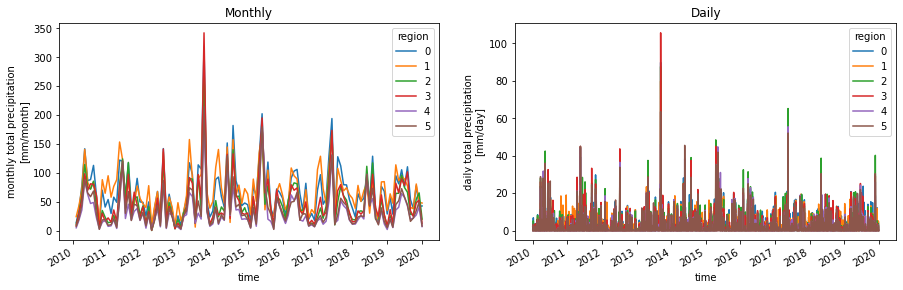

In [70]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))
daymet_prcp_regions_ts.plot(ax=ax1, hue="region")
ax1.set_title('Monthly')
daymet_prcp_regions_ts_daily.plot(ax=ax2, hue="region")
ax2.set_title('Daily');

#### Evapotranspiration

In [71]:
ssebop_et_regions_ts = generate_huc10_ts(uy_huc10_regions, uy_ssebop_et_ds, 'et', crsvar='crs')

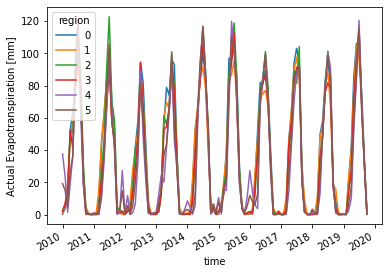

In [72]:
ssebop_et_regions_ts.plot(hue="region");

#### Water storage

In [73]:
grace_lwe_thickness_regions_ts = generate_huc10_ts(uy_huc10_regions, uy_grace_lwe_thickness_ds, 'lwe_thickness')

In [74]:
grace_lwe_thickness_regions_ts

<xarray.DataArray 'lwe_thickness' (time: 90, region: 6)>
array([[nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
...
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan]])
Coordinates:
  * time     (time) datetime64[ns] 2010-01-16T12:00:00 ... 2019-12-16T12:00:00
  * region   (region) int64 0 1 2 3 4 5
    abbrevs  (region) <U2 'r0' 'r1' 'r2' 'r3' 'r4' 'r5'
    names    (region) <U10 '1019000601' '1019000602' ... '1019000606'
Attributes:
    long_name:  Liquid_Water_Equivalent_Thickness
    units:      cm

**Convert units to mm**, and update units attribute accordingly.

In [75]:
grace_lwe_thickness_regions_ts *= 10
grace_lwe_thickness_regions_ts.attrs['units'] = 'mm/month'

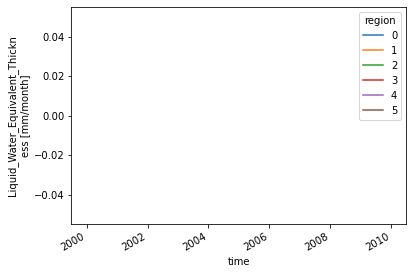

In [76]:
grace_lwe_thickness_regions_ts.plot(hue="region");

- Because the GRACE cells are so coarse, a single cell spans the whole Upper Yakima and the behavior of the sub-watersheds is effectively identical.
- Note that the **length of the `time` dimension is 9, not 12!** There are gaps in this dataset, likely due to GRACE data availability and processing.

----------------
## All three water budget elements, plotted and converted to BigThompson-watershed DataFrames

For clarity and comparability, set sub-plot titles and set a common y-axis value range; for water storage, the ymin and ymax values are different, but the range is still the same.

In [77]:
yrange = 400 # in mm

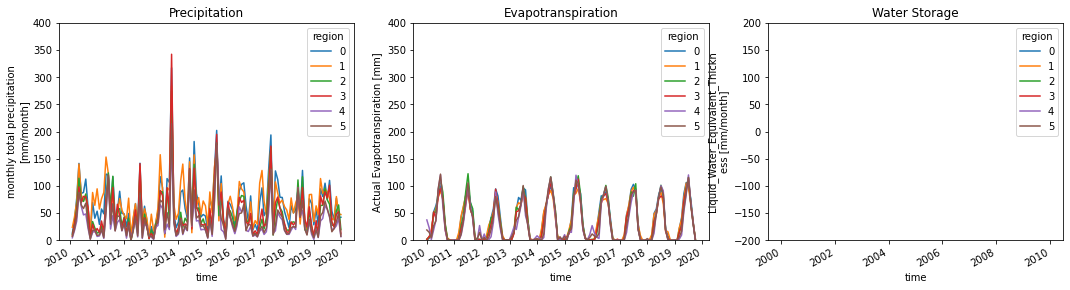

In [78]:
f, ax = plt.subplots(ncols=3, figsize=(18, 4))
daymet_prcp_regions_ts.plot(ax=ax[0], hue="region")
ax[0].set_title('Precipitation')
ax[0].set_ylim(0, yrange)
ssebop_et_regions_ts.plot(ax=ax[1], hue="region")
ax[1].set_title('Evapotranspiration')
ax[1].set_ylim(0, yrange)
grace_lwe_thickness_regions_ts.plot(ax=ax[2], hue="region")
ax[2].set_title('Water Storage')
ax[2].set_ylim(-200, -200 + yrange);

### Whole-watershed DataFrames

Generate UY-wide PPT, ET and LWE_thickness time series from HUC10-level values.

In [79]:
uy_huc10_gdf['areaweight'] = uy_huc10_gdf.areasqkm.values / uy_huc10_gdf.areasqkm.sum()

In [80]:
def generate_uy_ts(da, davarname):
    """
    Calculate whole-watershed time series based on area-weighted averaging of
    HUC10-level time series, converting from DataArray to DataFrame.
    Returns a cleaned and consistent DataFrame
    """
    areawt = xr.DataArray(
        uy_huc10_gdf.areasqkm.values / uy_huc10_gdf.areasqkm.sum(), 
        dims=('region'), 
        coords={'region': uy_huc10_gdf.index}
    )
    uy_ts = da.weighted(areawt).mean(dim=("region"))
    # Assign dataarray name
    uy_ts.name = davarname
    uy_ts_df = uy_ts.to_dataframe()
    uy_ts_df.index = uy_ts_df.index.month
    uy_ts_df.index.name = 'month'
    
    return uy_ts_df

#### Precipitation

In [81]:
daymet_prcp_uy_ts_df = generate_uy_ts(daymet_prcp_regions_ts, 'prcp')
daymet_prcp_uy_ts_df

,prcp
month,
1,12.341236
2,28.972020
3,56.623660
4,111.308100
5,73.582190
...,...
8,30.174351
9,28.301280
10,53.665408


#### Evapotranspiration

In [82]:
ssebop_et_uy_ts_df = generate_uy_ts(ssebop_et_regions_ts, 'et')

#### Water storage

In [83]:
grace_lwe_thickness_uy_tsdf = generate_uy_ts(grace_lwe_thickness_regions_ts, 'lwe_thickness')
grace_lwe_thickness_uy_tsdf

,lwe_thickness
month,
1,NaN
2,NaN
3,NaN
4,NaN
5,NaN
...,...
8,NaN
9,NaN
10,NaN


----------------
## READ WATER DATA: USGS NWIS river discharge near Upper Yakima outlet

<div class="alert alert-info" style="font-size:100%">
Convert to monthly scale. Convert discharge to mm/month based on watershed area. We could use <b>ulmo</b>, but for our purposes getting the data through <b>hydrodata</b> is more convenient.
</div>

Let's first use the convenience `hydrodata.interactive_map`. It uses Folium, so we can add other elements on top! We'll add HUC10 boundaries.

In [70]:
m2 = hd.interactive_map(tuple(uy_bbox.total_bounds))

In [71]:
for i, i_gdf in uy_huc10_gdf.iterrows():
    folium.GeoJson(
        i_gdf.geometry,
        style_function=lambda feature: {'color': 'black', 'fillOpacity': 0.0},
        tooltip=i_gdf['huc10']
    ).add_child(
        folium.Popup(f"<b>HUC10:</b><br> {i_gdf['huc10']}<br><b>watershed area:</b><br> {i_gdf['areasqkm']:.0f} km^2")
    ).add_to(m2)


m2.fit_bounds(m2.get_bounds())

The site markers are clickable, yielding rich information about the gages. This functionality is from `hydrodata.interactive_map`.

In [72]:
m2

<div class="alert alert-success" style="font-size:100%">
<b style="font-size:120%">Note:</b> The station near the mouth doesn't have recent data. Station 12484500 is the best, most downstream station with continuous data. But it's well upstream of the UY outlet and misses HUC10 sub-watersheds 1703000107 and 1703000106. Those two watersheds are pretty arid, so they probably don't add much water. The runoff (height / area) calculated from station 12484500 will be an overestimate.
    
Check out the <a href="https://waterdata.usgs.gov/monitoring-location/12484500/">USGS Station Page for 12484500</a>.
</div>

In [73]:
nwis = hd.NWIS()

In [74]:
nearestoutlet_sitecode = '12484500'

With `mmd=True`, `nwis.get_streamflow` converts cms (cubic meters / second) to mmd (mm/day) based on the contributing drainage area of the station.

In [75]:
nwis_q_daily_ts = nwis.get_streamflow([nearestoutlet_sitecode], dates=(date_start, date_end), mmd=True)

In [76]:
nwis_q_daily_ts.head()

,USGS-12484500
dateTime,
2016-01-01,0.624615
2016-01-02,0.654359
2016-01-03,0.684102
2016-01-04,0.713846
2016-01-05,0.713846


Resample to daily and tweak it so it's consistent with the other watershed-scale time series.

In [77]:
nwis_q_ts_df = nwis_q_daily_ts.resample('1M').sum()
nwis_q_ts_df.index = nwis_q_ts_df.index.month
nwis_q_ts_df.index.name = 'month'
nwis_q_ts_df.rename(columns={'USGS-12484500': 'disch'}, inplace=True)

nwis_q_ts_df

,disch
month,
1,24.461119
2,67.256181
3,68.207976
4,98.939042
5,66.738643
6,50.867469
7,72.062743
8,68.856386
9,26.334965


## FINALLY! Create a single monthly budget Pandas DataFrame by concatenaing the 4 individual DataFrames

In [78]:
monthlybudget_df = pd.concat([daymet_prcp_uy_ts_df, ssebop_et_uy_ts_df, nwis_q_ts_df, grace_lwe_thickness_uy_tsdf], 
                             axis='columns')
monthlybudget_df

,prcp,et,disch,lwe_thickness
month,,,,
1,146.410693,1.195471,24.461119,61.115773
2,102.053580,5.900374,67.256181,107.860667
3,128.824438,4.804062,68.207976,168.040942
4,23.201055,10.836575,98.939042,NaN
5,46.216485,34.268903,66.738643,-7.889412
6,30.073746,38.624489,50.867469,-58.538181
7,23.676077,84.600587,72.062743,-116.443497
8,3.942106,45.486203,68.856386,-197.939320
9,22.664322,17.236319,26.334965,NaN


Let's calculate a budget "delta" based on the difference between the three watershed-scale water flux (mm/month) terms.

In [79]:
# "eval" is a convenient Pandas construct
monthlybudget_df['delta'] = monthlybudget_df.eval('prcp - et - disch')

Plot all the time series together, plus a scatter plot of "delta" vs lwe_thickness; that's a decent correlation, for such vastly different sources of data going into these calculations!

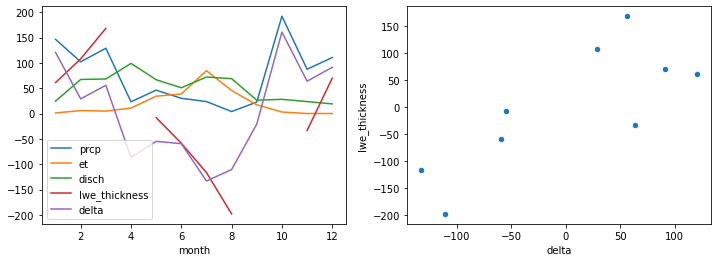

In [80]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,4))
monthlybudget_df.plot(ax=ax1)
monthlybudget_df.plot(ax=ax2, x='delta', y='lwe_thickness', kind='scatter');

----------------
## Package versions
It's useful to have this reference for reproducibility.

In [81]:
pd.__version__, gpd.__version__, xr.__version__, rioxarray.__version__, rm.__version__, hd.__version__

('1.0.5', '0.8.1', '0.16.0', '0.0.31', '0.6.1', '0.7.2')